In [1]:
import torch
import torchvision as tv
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from sklearn.model_selection import KFold
import numpy as np
import torch.optim as optim
from tqdm.auto import tqdm
from timeit import default_timer as timer
from copy import deepcopy
from torchvision import transforms
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from torch.optim.lr_scheduler import StepLR

In [2]:
try:
   from torchmetrics import ConfusionMatrix
except:
    !pip install torchmetrics
    from torchmetrics import ConfusionMatrix

conmat=ConfusionMatrix(task='multiclass',num_classes=3)
conmat=conmat

In [3]:
# Check if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [4]:
torch.manual_seed(71)
torch.cuda.manual_seed(71)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading data

In [6]:
train_dir = "/content/drive/MyDrive/DataMiningCW/train"
test_dir = "/content/drive/MyDrive/DataMiningCW/test"


In [7]:
data = pd.read_csv('/content/drive/MyDrive/DataMiningCW/train.csv', usecols=['ID', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Credit_Card', 'Interest_Rate', 'Delay_from_due_date', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Total_EMI_per_month', 'Credit_Score'])

In [8]:
data.head()

,ID,Annual_Income,Monthly_Inhand_Salary,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Total_EMI_per_month,Credit_Score
0,5634,19114.12,1824.843333,4.0,3.0,3.0,11.27,4.0,809.98,49.574949,Good
1,5635,19114.12,1824.843333,4.0,3.0,3.0,11.27,4.0,809.98,49.574949,Good
2,5636,19114.12,1824.843333,4.0,3.0,3.0,11.27,4.0,809.98,49.574949,Good
3,5637,19114.12,1824.843333,4.0,3.0,5.0,6.27,4.0,809.98,49.574949,Good
4,5638,19114.12,1824.843333,4.0,3.0,6.0,11.27,4.0,809.98,49.574949,Good


In [9]:
data['Credit_Score'], _ = pd.factorize(data['Credit_Score'])

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     100000 non-null  int64  
 1   Annual_Income          100000 non-null  float64
 2   Monthly_Inhand_Salary  100000 non-null  float64
 3   Num_Credit_Card        100000 non-null  float64
 4   Interest_Rate          100000 non-null  float64
 5   Delay_from_due_date    100000 non-null  float64
 6   Changed_Credit_Limit   100000 non-null  float64
 7   Num_Credit_Inquiries   100000 non-null  float64
 8   Outstanding_Debt       100000 non-null  float64
 9   Total_EMI_per_month    100000 non-null  float64
 10  Credit_Score           100000 non-null  int64  
dtypes: float64(9), int64(2)
memory usage: 8.4 MB


In [11]:
data.isna().sum()

ID                       0
Annual_Income            0
Monthly_Inhand_Salary    0
Num_Credit_Card          0
Interest_Rate            0
Delay_from_due_date      0
Changed_Credit_Limit     0
Num_Credit_Inquiries     0
Outstanding_Debt         0
Total_EMI_per_month      0
Credit_Score             0
dtype: int64

In [12]:
scaler = StandardScaler()
features = data[['Annual_Income', 'Monthly_Inhand_Salary', 'Num_Credit_Card', 'Interest_Rate', 'Delay_from_due_date', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Total_EMI_per_month']]  # all columns except the target
target = data['Credit_Score']

# Normalize features
features_normalized = scaler.fit_transform(features)

In [13]:
# Splitting data into training, test and validation
features_train, features_temp, target_train, target_temp = train_test_split(
    features_normalized, target, test_size=0.4, random_state=42)  

features_val, features_test, target_val, target_test = train_test_split(
    features_temp, target_temp, test_size=0.5, random_state=42)  

# Applying Smote

In [14]:
smote = SMOTE(random_state=42)
features_train, target_train = smote.fit_resample(features_train, target_train)

# Preparing data for neural network

In [15]:
train_features = torch.tensor(features_train, dtype = torch.float32)
train_targets = torch.tensor(target_train, dtype = torch.int64).squeeze()

In [16]:
target_val = target_val.to_numpy()

In [17]:
val_features = torch.tensor(features_val, dtype = torch.float32)
val_targets = torch.tensor(target_val, dtype = torch.int64).squeeze()

In [18]:
target_test = target_test.to_numpy()

In [19]:
test_features = torch.tensor(features_test, dtype = torch.float32)
test_targets = torch.tensor(target_test, dtype = torch.int64).squeeze()

In [20]:
# Create Tensor datasets
train_dataset = TensorDataset(train_features, train_targets)
test_dataset = TensorDataset(test_features, test_targets)
val_dataset = TensorDataset(val_features, val_targets)

# Setup DataLoaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False )

# Useful functions

In [32]:
def train_model(model, train_loader, val_loader, epochs, optimizer, scheduler, criterion):
    """
    Function to train the neural networks. The model is trained on the training data and the weights are updated at each epoch.
    Params:
        model: The neural network to be trained
        train_loader: The training data in batches
        val_loader: The validation data in batches
        epochs: The number of epochs to train the model for
        optimizer: The optimizer used for convergence
        scheduler: Scheduler to lower the learning rate during trianing 
        criterion: Loss criterion to measure the performance of the model after each training epoch 
    """
    num_epochs = epochs
    for epoch in range(num_epochs):
        model.train()
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.cuda(), labels.cuda()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        # Calculate validation loss and step the scheduler
        val_loss = validate(model, val_loader, criterion)
        scheduler.step(val_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}')

In [22]:
def get_all_predictions(model, data_loader):
    """
    Function to get all the predicted values and their actual labels
    Params:
        model: The trained neural network model
        data_loader: The test data loader
    Returns:
        all_preds: All predicted labels
        all_labels: All the true labels
    """
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

In [23]:
def compute_metrics(predictions, true_labels):
    """
    Function to compute evaluation metrics for the trained models
    Params:
        predictions: The predicted labels
        true_labels: The true labels
    Returns:
        precision: The precision of the model
        recall: The recall of the model
        f1: The F1 score of the model
        accuracy: The accuracy of the model
        conf_matrix: The confusion matrix
    """
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')
    accuracy = accuracy_score(true_labels, predictions)
    conf_matrix = confusion_matrix(true_labels, predictions)

    return precision, recall, f1, accuracy, conf_matrix

In [24]:
def plot_confusion_matrix(conf_matrix, class_names):
    """
    Function to plot the confusion matrix
    Params:
        conf_matrix: The cgenerated confusion matrix
        class_names: The names of each class
    """
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [25]:
def evaluate_model(model, data_loader):
    """
    Function to print out all the evaluation metrics
    Params:
        model: The trained model
        data_loader: Test data loader
    """
    predictions, true_labels = get_all_predictions(model, data_loader)

    # Compute metrics
    precision, recall, f1, accuracy, conf_matrix = compute_metrics(predictions, true_labels)

    print(f'Precision: {precision*100}%')
    print(f'Recall: {recall*100}%')
    print(f'F1 Score: {f1*100}%')
    print(f'Accuracy: {accuracy*100}%')
    print("Confusion Matrix:\n", conf_matrix)

In [26]:
def validate(model, val_loader, criterion):
    """
    Function to run a validation loop at the end of each training epoch on the valdiation dataset
    Params:
        model: The trained model
        val_loader: The validaton data laoder in batches
        criterion: The loss criterion to evaluate the performance of the model
    Returns:
        The loss of the model at the end of each epoch
    """
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item() * data.size(0)
    return total_loss / len(val_loader.dataset)

# Neural Networks

# Architecture 1: Two convolution layers, one max pooling layer, and two fully connected layers

In [27]:
class SimpleCNN1D(nn.Module):
    def __init__(self):
        super(SimpleCNN1D, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, 3, 1)
        self.conv2 = nn.Conv1d(16, 32, 3, 1)
        self.pool = nn.MaxPool1d(2, 2)
        self.fc1 = nn.Linear(32 * 2, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [28]:
model = SimpleCNN1D()
model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
#optimizer = optim.SGD(params = model.parameters(), lr = 0.0005)
#optimizer = optim.RMSprop(params = model.parameters(), lr = 0.0001)
#scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

In [29]:
train_model(model, train_loader, val_loader, 20, optimizer, scheduler, criterion)

Epoch [1/20], Step [100/375], Loss: 1.0134
Epoch [1/20], Step [200/375], Loss: 0.8620
Epoch [1/20], Step [300/375], Loss: 0.9261
Epoch [1/20], Validation Loss: 0.8934
Epoch [2/20], Step [100/375], Loss: 0.8230
Epoch [2/20], Step [200/375], Loss: 0.8185
Epoch [2/20], Step [300/375], Loss: 0.7542
Epoch [2/20], Validation Loss: 0.8566
Epoch [3/20], Step [100/375], Loss: 0.8184
Epoch [3/20], Step [200/375], Loss: 0.8233
Epoch [3/20], Step [300/375], Loss: 0.7517
Epoch [3/20], Validation Loss: 0.8500
Epoch [4/20], Step [100/375], Loss: 0.8284
Epoch [4/20], Step [200/375], Loss: 0.8380
Epoch [4/20], Step [300/375], Loss: 0.7991
Epoch [4/20], Validation Loss: 0.8397
Epoch [5/20], Step [100/375], Loss: 0.7189
Epoch [5/20], Step [200/375], Loss: 0.6983
Epoch [5/20], Step [300/375], Loss: 0.7742
Epoch [5/20], Validation Loss: 0.8288
Epoch [6/20], Step [100/375], Loss: 0.8043
Epoch [6/20], Step [200/375], Loss: 0.7136
Epoch [6/20], Step [300/375], Loss: 0.7470
Epoch [6/20], Validation Loss: 0.829

In [30]:
evaluate_model(model, test_loader)

Precision: 67.87758833347148%
Recall: 61.045%
F1 Score: 61.11099606337309%
Accuracy: 61.045%
Confusion Matrix:
 [[2839  601  118]
 [3037 5034 2549]
 [ 800  686 4336]]


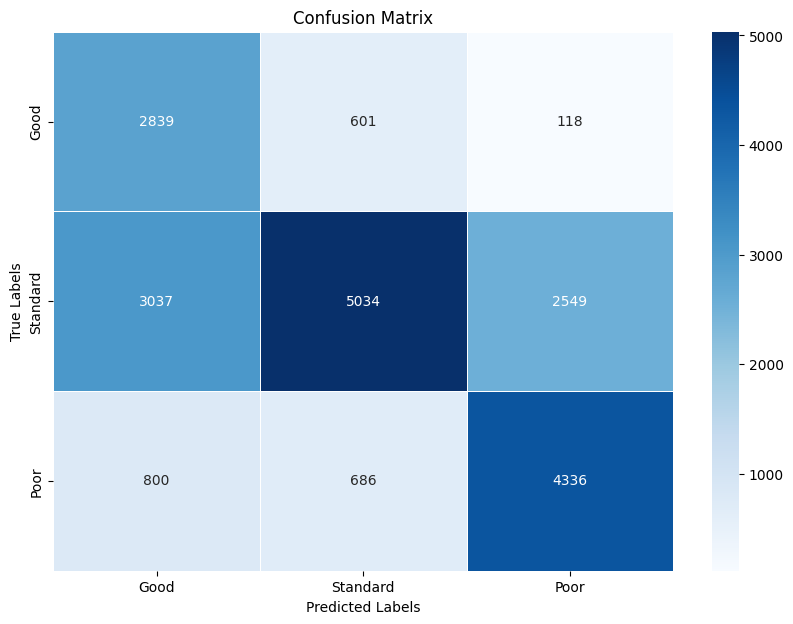

In [31]:
class_names = ["Good", "Standard", "Poor"]
predictions, true_labels = get_all_predictions(model, test_loader)
precision, recall, f1, accuracy, conf_matrix = compute_metrics(predictions, true_labels)
plot_confusion_matrix(conf_matrix, class_names)

# Architecture 2: 3 convolution layers with batch normalisation after each layer followed by a max pooling layer, two fully connected layers, each followed by a dropout layer

In [30]:
class EnhancedSimpleCNN1D(nn.Module):
    def __init__(self):
        super(EnhancedSimpleCNN1D, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, 3, 1, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, 3, 1, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 128, 3, 1, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool = nn.MaxPool1d(2, 2)
        self.dropout1 = nn.Dropout(0.4)
        self.fc1 = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = x.unsqueeze(1)  
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x


In [31]:
model = EnhancedSimpleCNN1D()
model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
#optimizer = optim.SGD(params = model.parameters(), lr = 0.0005)
#optimizer = optim.RMSprop(params = model.parameters(), lr = 0.0001)
#scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

In [32]:
train_model(model, train_loader, val_loader, 20, optimizer, scheduler, criterion)

Epoch [1/20], Step [100/375], Loss: 0.7734
Epoch [1/20], Step [200/375], Loss: 0.7395
Epoch [1/20], Step [300/375], Loss: 0.7681
Epoch [1/20], Validation Loss: 0.8023
Epoch [2/20], Step [100/375], Loss: 0.7599
Epoch [2/20], Step [200/375], Loss: 0.8233
Epoch [2/20], Step [300/375], Loss: 0.8043
Epoch [2/20], Validation Loss: 0.8037
Epoch [3/20], Step [100/375], Loss: 0.8401
Epoch [3/20], Step [200/375], Loss: 0.7680
Epoch [3/20], Step [300/375], Loss: 0.6502
Epoch [3/20], Validation Loss: 0.7974
Epoch [4/20], Step [100/375], Loss: 0.6918
Epoch [4/20], Step [200/375], Loss: 0.7368
Epoch [4/20], Step [300/375], Loss: 0.7399
Epoch [4/20], Validation Loss: 0.8072
Epoch [5/20], Step [100/375], Loss: 0.7812
Epoch [5/20], Step [200/375], Loss: 0.7289
Epoch [5/20], Step [300/375], Loss: 0.7608
Epoch [5/20], Validation Loss: 0.7920
Epoch [6/20], Step [100/375], Loss: 0.7559
Epoch [6/20], Step [200/375], Loss: 0.7311
Epoch [6/20], Step [300/375], Loss: 0.7380
Epoch [6/20], Validation Loss: 0.781

In [33]:
evaluate_model(model, test_loader)

Precision: 69.06311897862193%
Recall: 62.515%
F1 Score: 62.510933376798015%
Accuracy: 62.515%
Confusion Matrix:
 [[2881  565  112]
 [2800 5189 2631]
 [ 752  637 4433]]


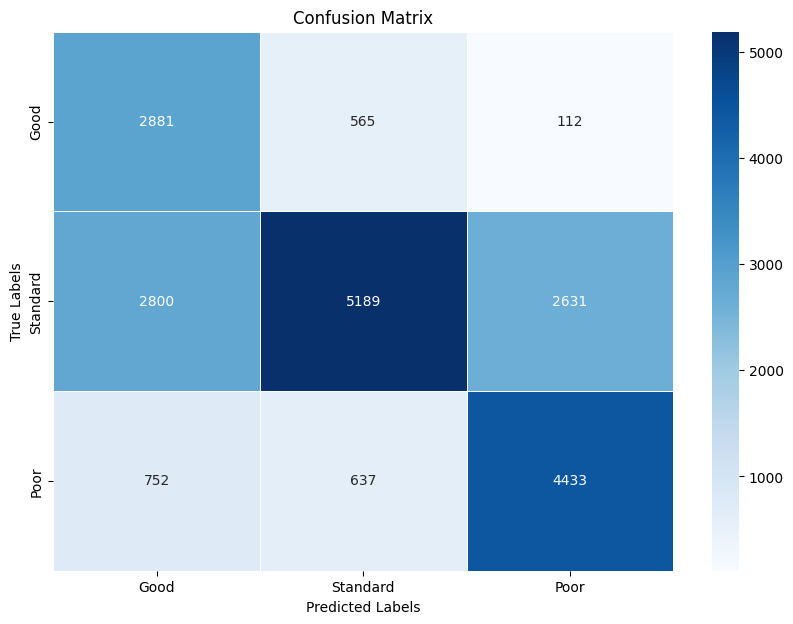

In [34]:
class_names = ["Good", "Standard", "Poor"]
predictions, true_labels = get_all_predictions(model, test_loader)
precision, recall, f1, accuracy, conf_matrix = compute_metrics(predictions, true_labels)
plot_confusion_matrix(conf_matrix, class_names)

# Architecture 3: VGG like architecture with 6 convolution layers, maxpooling every two layers, two dropout layers

In [29]:
class VGG_CNN(nn.Module):
    def __init__(self):
        super(VGG_CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),

            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 3)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [30]:
model = VGG_CNN()
model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
#optimizer = optim.SGD(params = model.parameters(), lr = 0.0005)
#optimizer = optim.RMSprop(params = model.parameters(), lr = 0.0001)
#scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

In [3]:
train_model(model, train_loader, val_loader, 20, optimizer, scheduler, criterion)

In [1]:
evaluate_model(model, test_loader)

In [2]:
class_names = ["Good", "Standard", "Poor"]
predictions, true_labels = get_all_predictions(model, test_loader)
precision, recall, f1, accuracy, conf_matrix = compute_metrics(predictions, true_labels)
plot_confusion_matrix(conf_matrix, class_names)